# Time Series Model Development (Python)

## Instructions 
__1)__ Identify a data set that is suitable for a time series prediction that we have not used in class.

__2)__ First create at least 3 different time-series models.

- Don't forget to split your data into training and testing (e.g., the final 12 months or final 52 weeks, assuming the data has calendar based seasonality).

- These models should only account for seasonality and trend. We are not attempting to account for other potential influencers.

__3)__ Then use each model to forecast at least one full final cycle of your data (e.g., final 12 months or 52 weeks) and graph your actual versus predicted results and residuals.

__4)__ Pick the best one and explain your choice using appropriate model statistics (e.g., RMSE) and your residual plots.

## Loading the Data
I will use historical cryptocurrency data related to Bitcoins sourced from [coindesk.com]. I will use the daily closing value as my target. (https://www.coindesk.com/price/bitcoin)

In [1]:
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 100})
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

df = pd.read_csv('https://raw.githubusercontent.com/gitjuli/AutoML/master/Data/BTC_USD_CoinDesk.csv', parse_dates=['Date'], index_col='Date')
df = df[['Closing Price (USD)']]
df.rename(columns={'Closing Price (USD)':'value'}, inplace=True)
df.head()

C:\Users\julir\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,value
Date,
2017-01-01,964.32500
2017-01-02,1009.97375
2017-01-03,1028.33375
2017-01-04,1047.09999
2017-01-05,1140.38500


In [2]:
# checking number of records
df.shape

(1396, 1)

In [3]:
# checking null values
df.isna().sum() 

value    0
dtype: int64

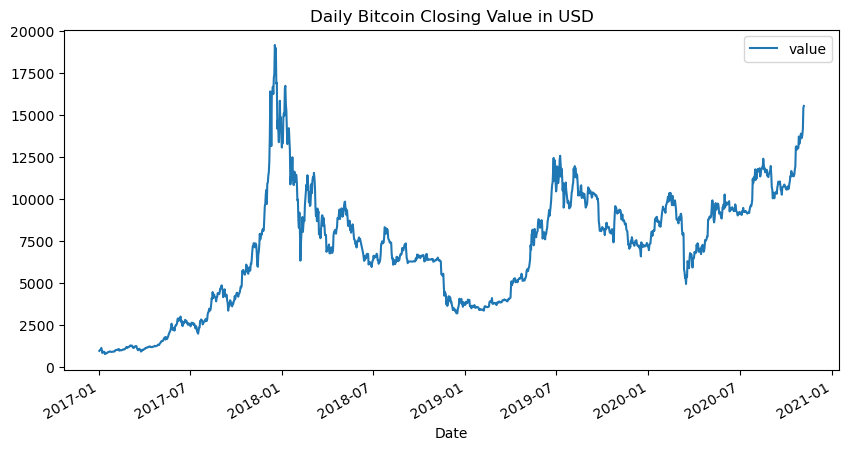

In [4]:
# ploting the data
df.plot(title='Daily Bitcoin Closing Value in USD')
plt.show()

There are several ups and downs across time suggesting that the series is not stationary and will require differencing to make it stationary. In addition there is no clear seasonality.

Year-wise boxplot to see the trend and Month-wise box plot to see the seasonality

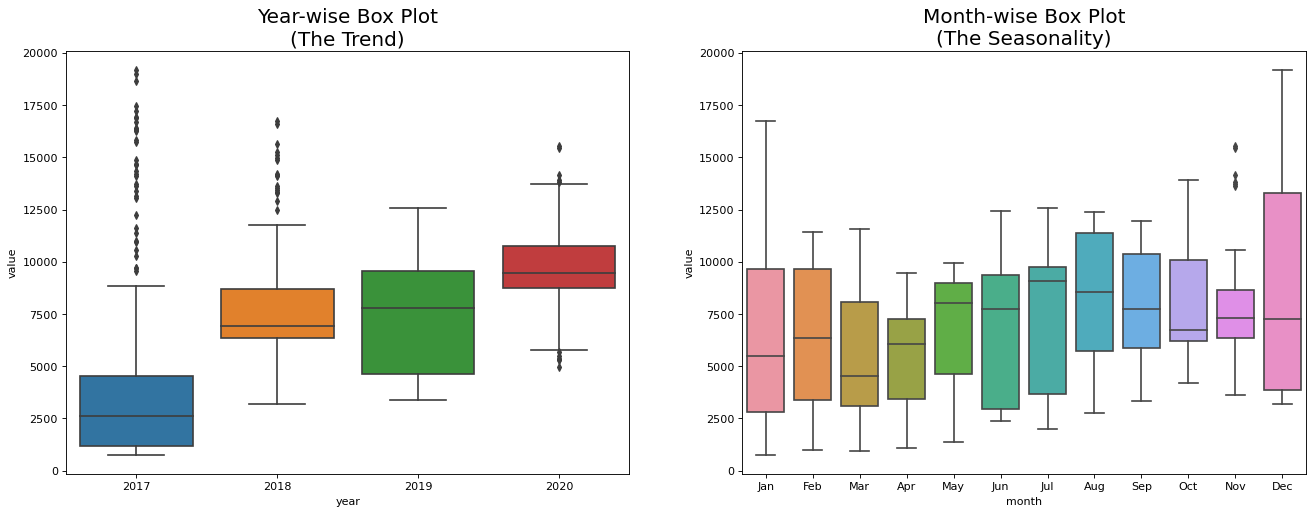

In [5]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

There is some upward trend in terms of years, and some sort of seasonality with lower values during March and April than the rest of the year.

In [6]:
df['value'] = df['value'].astype('float32')
df = df.value.to_frame()

## Testing Stationarity - Dickey Fuller test (ADH Test)

In [7]:
# ADF Test
def get_stationarity(data):
    result = adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

In [8]:
get_stationarity(df)

ADF Statistic: -1.7826352811797104
p-value: 0.38911623313614485
Critial Values:
   1%, -3.435080296942406
Critial Values:
   5%, -2.863629081525758
Critial Values:
   10%, -2.567882222497361


Given that the p-value is higher than the significance level (0.05) then the series is non-stationary

## Autocorrelation plot

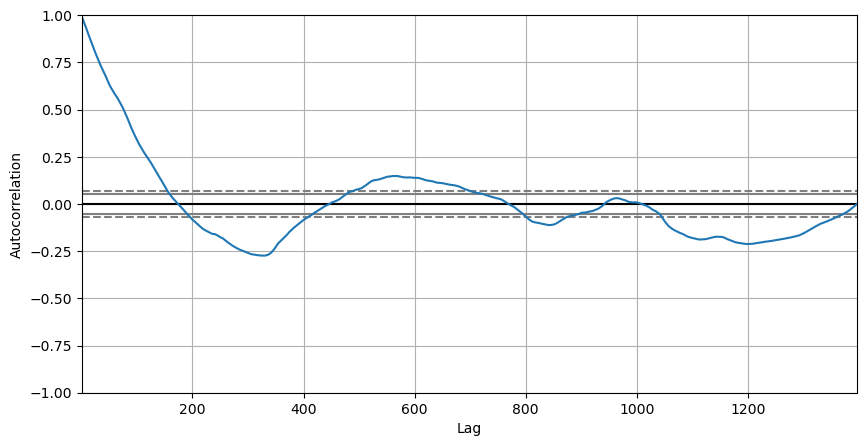

In [9]:
def get_autocorrelation_plot(data):
    autocorrelation_plot(data)
    pyplot.show()
    
get_autocorrelation_plot(df)

I can see that there is a positive correlation with the first 0-150 lags that is perhaps significant for the first 200 lags.
Finding parameters for ARIMA analyzing Autocorrelation and Partial Autocorrelation plots.

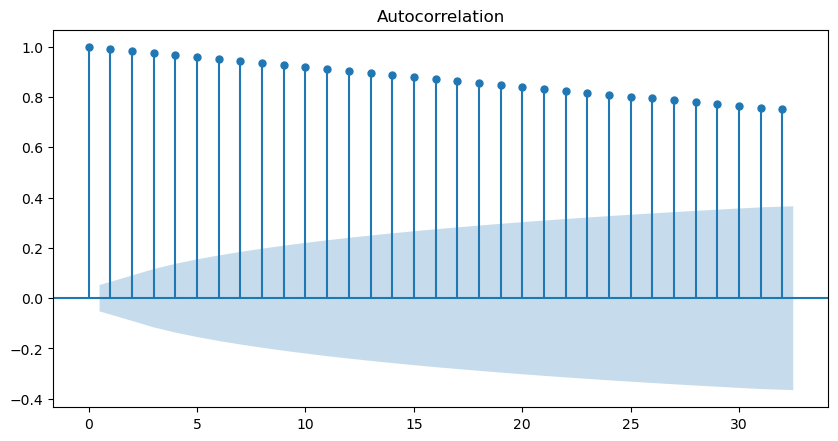

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df)
pyplot.show()

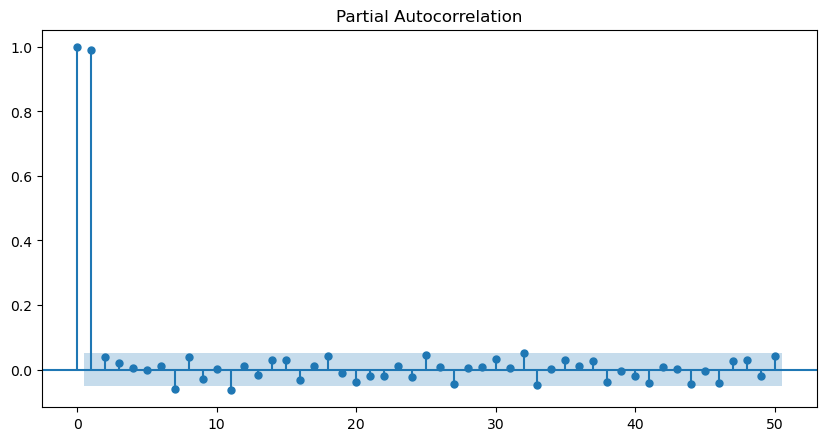

In [11]:
plot_pacf(df, lags=50)
pyplot.show()

For the above series, the time series seems to reach stationarity with one order of differencing. Lets confirm with the code below

In [12]:
## Adf Test
from pmdarima.arima.utils import ndiffs
ndiffs(df.value, test='adf')  # 2

1

For ARIMA it seems that parameters p,d,q value could be 1

## Making the series stationary
### Subtracting the Trend Component

Text(0.5, 0.98, 'Multiplicative Decompose')

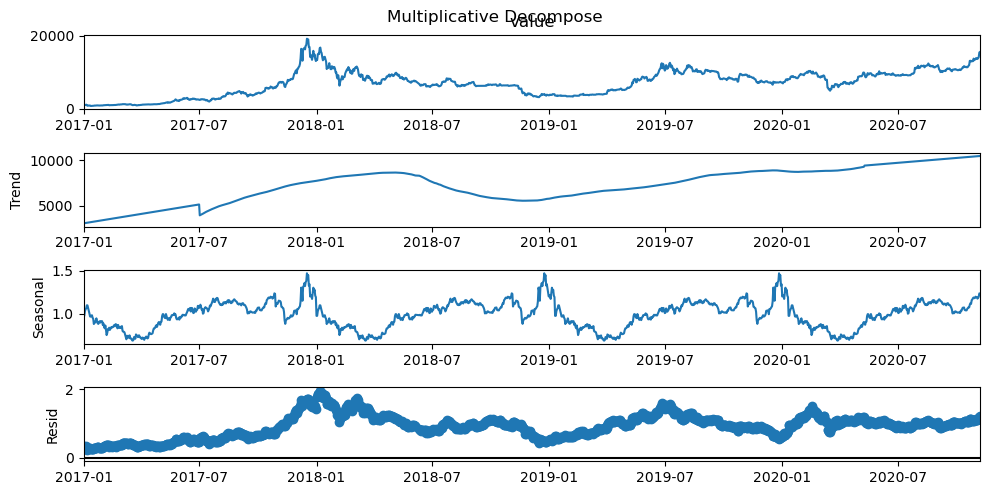

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq', period=365)
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=12)

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

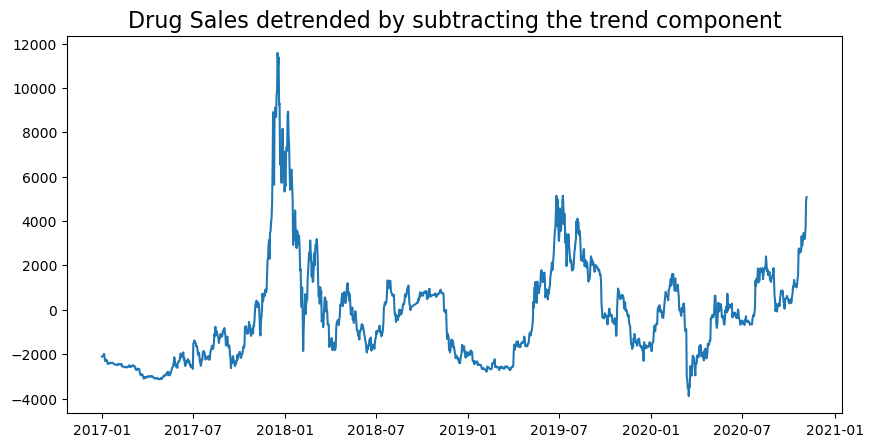

In [14]:
# Using statmodels: Subtracting the Trend Component.
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

In [15]:
get_stationarity(detrended)

ADF Statistic: -2.938443486424273
p-value: 0.041056711596207246
Critial Values:
   1%, -3.435080296942406
Critial Values:
   5%, -2.863629081525758
Critial Values:
   10%, -2.567882222497361


Now I see that the p-value is below the threshold 0.05, so the series is now stationary.

## Creating ARIMA Models

First I get last 365 observations as the full final cycle of the data, and assign it to be the testing set.

In [28]:
X = detrended.values
start_testing = len(X) - 365

In [42]:
train, test = X[0:start_testing], X[start_testing:len(X)]
print('training length:', len(train), ', testing length:', len(test))

training length: 1031 , testing length: 365


In [36]:
def evaluate_arima(order_param):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order_param)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    return error, predictions
    #print('Test MSE: %.3f' % error)

In [43]:
model1_mse, model1_pred = evaluate_arima((1,1,0))
model2_mse, model2_pred = evaluate_arima((2,1,0))
model3_mse, model3_pred = evaluate_arima((2,2,0))

C:\Users\julir\Anaconda3\envs\mmf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test MSE: 88029.451


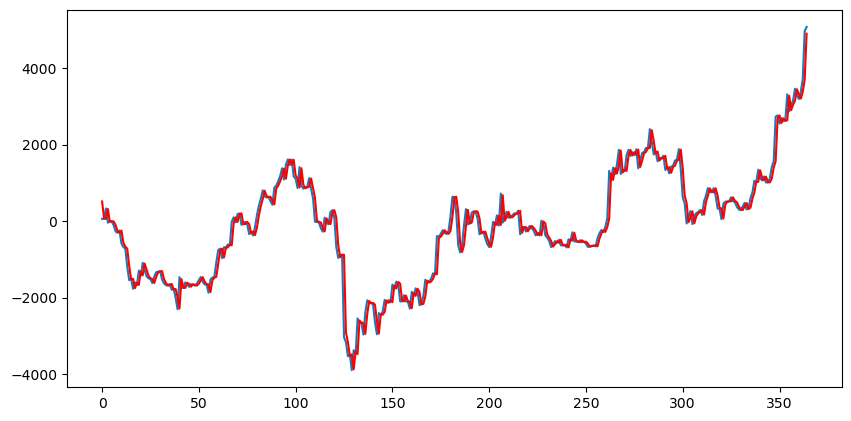

In [44]:
# model 1
print('Test MSE: %.3f' % model1_mse)
pyplot.plot(test)
pyplot.plot(model1_pred, color='red')
pyplot.show()

Test MSE: 87858.095


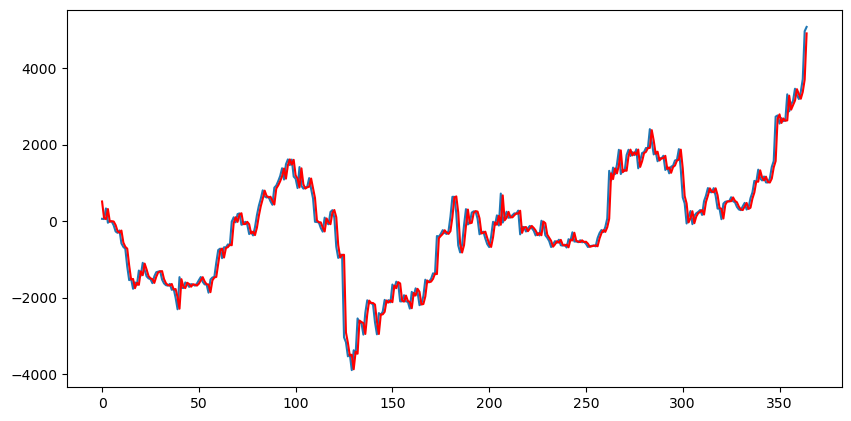

In [45]:
# model 2
print('Test MSE: %.3f' % model2_mse)
pyplot.plot(test)
pyplot.plot(model2_pred, color='red')
pyplot.show()

Test MSE: 115001.616


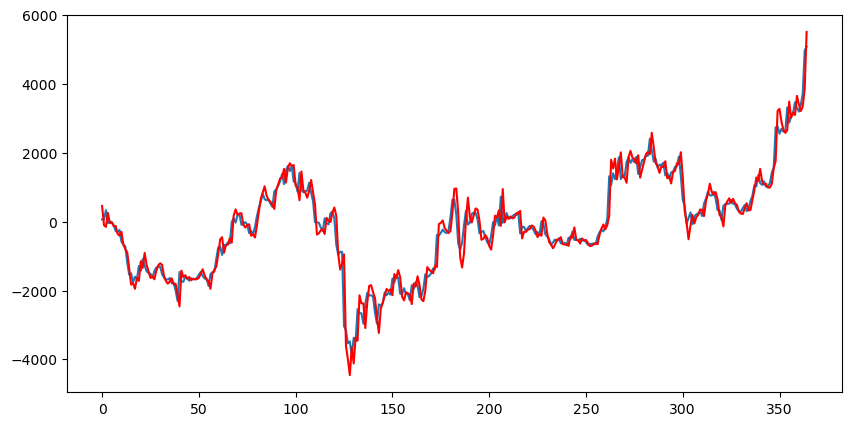

In [46]:
# model 3
print('Test MSE: %.3f' % model3_mse)
pyplot.plot(test)
pyplot.plot(model3_pred, color='red')
pyplot.show()

The lowest MSE corresponds to model 2 so it is the selected model. Looking at the residual plot of the selected model below.

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1030
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -7597.331
Method:                       css-mle   S.D. of innovations            386.491
Date:                Sun, 08 Nov 2020   AIC                          15202.663
Time:                        11:37:25   BIC                          15222.412
Sample:                             1   HQIC                         15210.158
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5440     11.478      0.222      0.825     -19.953      25.041
ar.L1.D.y     -0.0595      0.031     -1.911      0.056      -0.121       0.002
ar.L2.D.y      0.0103      0.031      0.331      0.7

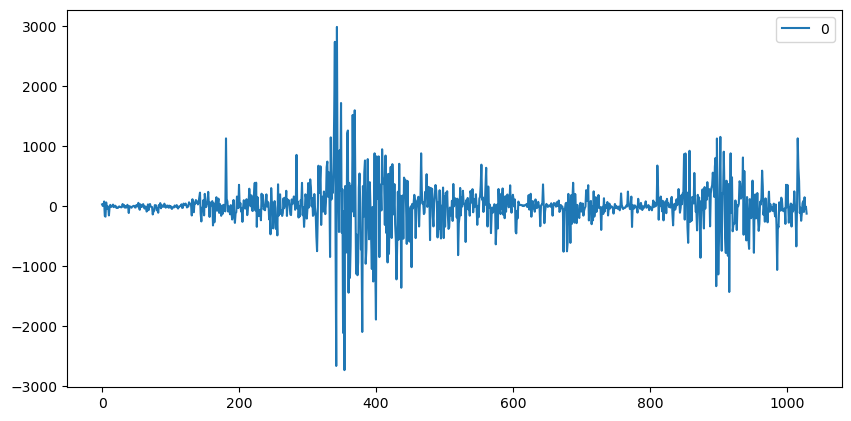

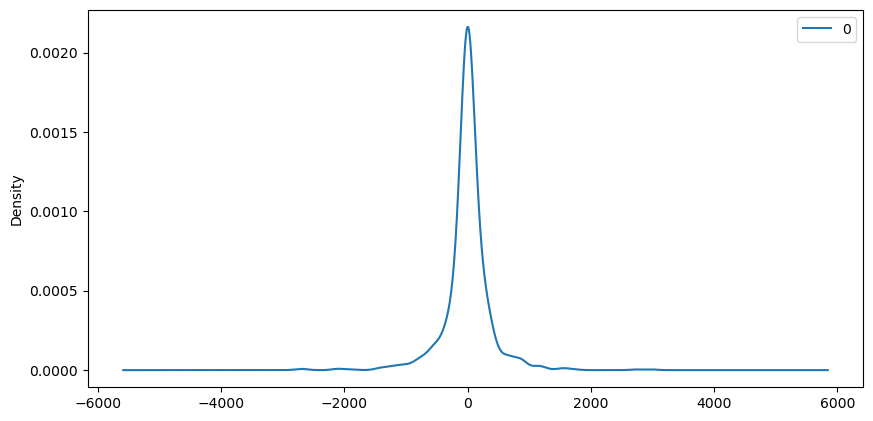

                 0
count  1030.000000
mean      0.005021
std     386.679112
min   -2729.470031
25%     -88.203075
50%       1.670514
75%     113.001626
max    2987.124848


In [49]:
series = [x for x in train]
# fit model
model = ARIMA(series, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

The residuals show a Gaussian distribution and despite is the model with the lowest MSE there is still some trend information not captured by the model.